## Copied from arch univariate_volatility_modeling

_This setup code is required to run in an IPython notebook_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [3]:
import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_close from USEQ_HIST where symbol='MS'
    and volume>0 order by tradedate''',
    conn,
    index_col='tradedate'
)

df = pd.DataFrame(SQL_query, columns=['pct_close'])

df.head()


,pct_close
tradedate,
2016-01-04,-1.03741
2016-01-05,-0.63532
2016-01-06,-2.49361
2016-01-07,-4.98361
2016-01-08,-2.07039


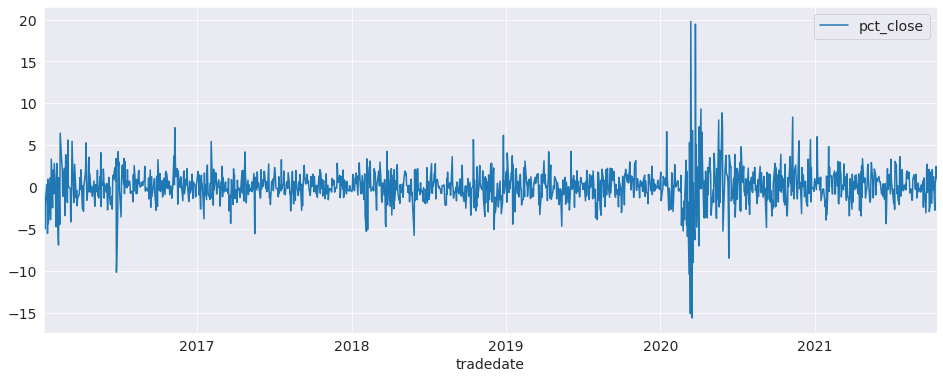

In [4]:
ax = df.plot()
xlim = ax.set_xlim(df.index.min(), df.index.max())

In [5]:
from arch import arch_model

am = arch_model(df)
res = am.fit(update_freq=5)
print(res.summary())
print("likelihood ", res.loglikelihood)

Iteration:      5,   Func. Count:     37,   Neg. LLF: 2907.6378947931794
Iteration:     10,   Func. Count:     69,   Neg. LLF: 2906.6550933955677
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2906.6550000984034
            Iterations: 12
            Function evaluations: 81
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2906.66
Distribution:                  Normal   AIC:                           5821.31
Method:            Maximum Likelihood   BIC:                           5842.44
                                        No. Observations:                 1456
Date:                Tue, Oct 19 2021   Df Residuals:                     1455
Time:      

`plot()` can be used to quickly visualize the standardized residuals and conditional volatility.


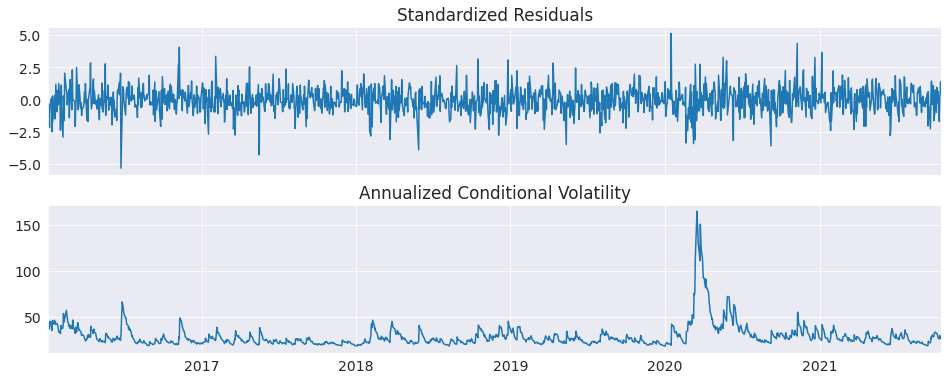

In [6]:
fig = res.plot(annualize="D")

## Forecasts

In [7]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

                 h.1
tradedate           
2021-10-15  0.127442
                 h.1
tradedate           
2021-10-15  2.991115
                 h.1
tradedate           
2021-10-15  2.991115
                 h.1       h.2       h.3       h.4       h.5
tradedate                                                   
2021-10-15  2.991115  3.039503  3.084297  3.125764  3.164151


### GJR-GARCH

In [8]:
am = arch_model(df, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2894.72
Distribution:                  Normal   AIC:                           5799.44
Method:            Maximum Likelihood   BIC:                           5825.85
                                        No. Observations:                 1456
Date:                Tue, Oct 19 2021   Df Residuals:                     1455
Time:                        13:07:31   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0845  4.327e-02      1.952  5.091e-02 [-3.33

## Forecasts

In [9]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])

                 h.1
tradedate           
2021-10-15  0.084475
                 h.1       h.2       h.3       h.4       h.5
tradedate                                                   
2021-10-15  2.956538  2.999952  3.040819  3.079289  3.115502


The log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is significant.

### TARCH/ZARCH

In [10]:
am = arch_model(df, p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     45,   Neg. LLF: 2906.016396644649
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2896.9011521200164
Iteration:     15,   Func. Count:    119,   Neg. LLF: 2896.885165846258
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2896.8851658465574
            Iterations: 15
            Function evaluations: 119
            Gradient evaluations: 15
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:              pct_close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -2896.89
Distribution:                  Normal   AIC:                           5803.77
Method:            Maximum Likelihood   BIC:                           5830.19
                                        No. Observations:                 1456
Date:             

The fit hasn't changed much
### Student's T Errors

Financial returns are often heavy tailed, and a Student's T distribution is a simple method to capture this feature.  The call to `arch` changes the distribution from a Normal to a Students's T.

The standardized residuals appear to be heavy tailed with an estimated degree of freedom near 6. (nu =~ 6 which is 8-2, 2 dofs for mean and std dev?) The log-likelihood also shows a large increase.

In [11]:
am = arch_model(df, p=1, o=1, q=1, power=1.0, dist="StudentsT")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 2852.1603570826906
Iteration:     10,   Func. Count:     94,   Neg. LLF: 2842.2878467715705
Iteration:     15,   Func. Count:    134,   Neg. LLF: 2841.978212270187
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2841.978211593212
            Iterations: 15
            Function evaluations: 135
            Gradient evaluations: 15
                     Constant Mean - TARCH/ZARCH Model Results                      
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      TARCH/ZARCH   Log-Likelihood:               -2841.98
Distribution:      Standardized Student's t   AIC:                           5695.96
Method:                  Maximum Likelihood   BIC:                           5727.66
                                              No. Observation

## GJR-Garch with Student's T

In [12]:
am = arch_model(df, p=1, o=1, q=1, dist="StudentsT")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     47,   Neg. LLF: 2846.301173323079
Iteration:     10,   Func. Count:     92,   Neg. LLF: 2842.1377495465836
Iteration:     15,   Func. Count:    137,   Neg. LLF: 2841.3533068761126
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2841.3528569735336
            Iterations: 18
            Function evaluations: 162
            Gradient evaluations: 18
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2841.35
Distribution:      Standardized Student's t   AIC:                           5694.71
Method:                  Maximum Likelihood   BIC:                           5726.41
                                              No. Observatio

## Forecasts

In [13]:
forecasts = res.forecast(reindex=False)
print(forecasts.mean.iloc[-3:])

forecasts = res.forecast(horizon=5, reindex=False)
print(forecasts.residual_variance.iloc[-3:])


                 h.1
tradedate           
2021-10-15  0.080417
                 h.1       h.2       h.3       h.4       h.5
tradedate                                                   
2021-10-15  3.076277  3.122709  3.167488  3.210674  3.252322


## Fixing Parameters
In some circumstances, fixed rather than estimated parameters might be of interest.  A model-result-like class can be generated using the `fix()` method.  The class returned is identical to the usual model result class except that information about inference (standard errors, t-stats, etc) is not available.

In [14]:
fixed_res = am.fix([0.0235, 0.01, 0.06, 0.0, 0.9382, 8.0])
print(fixed_res.summary())

                       Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                     pct_close   R-squared:                          --
Mean Model:                    Constant Mean   Adj. R-squared:                     --
Vol Model:                         GJR-GARCH   Log-Likelihood:               -2876.14
Distribution:       Standardized Student's t   AIC:                           5764.28
Method:            User-specified Parameters   BIC:                           5795.98
                                               No. Observations:                 1456
Date:                       Tue, Oct 19 2021                                         
Time:                               13:07:32                                         
      Mean Model     
                 coef
---------------------
mu             0.0235
   Volatility Model  
                 coef
---------------------
omega          0.0100
alpha[1]       0.0600
gamma[1]       0.0000
beta[1

(16804.0, 18915.0)

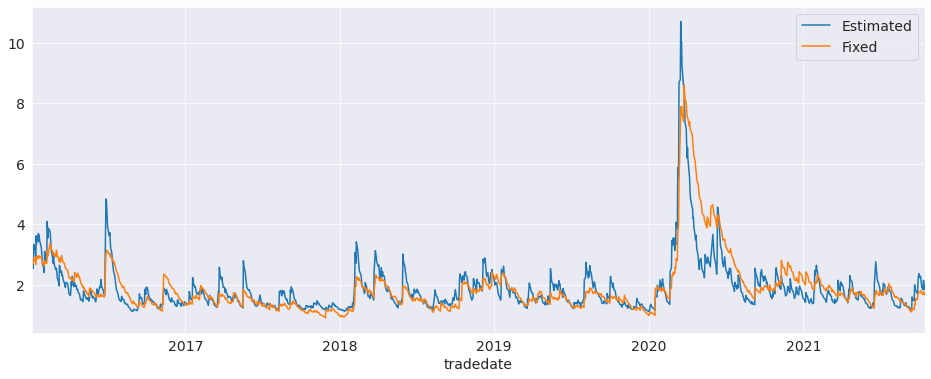

In [15]:
import pandas as pd

df = pd.concat([res.conditional_volatility, fixed_res.conditional_volatility], 1)
df.columns = ["Estimated", "Fixed"]
subplot = df.plot()
subplot.set_xlim(xlim)


## Forecasting

In [16]:
# am = arch_model(df)
# res = am.fit(update_freq=5)

In [17]:
# forecasts = res.forecast(reindex=False)

In [18]:
conn.close()